In [93]:
import pandas as pd
import os


column_names = ['Image', 'Attention']

df_attention = pd.read_csv('attention.csv', header=None, names=column_names)
df_shape_train = pd.read_csv('./featurebyshape/shape_train.csv')
df_shape_train_aug = pd.read_csv('./featurebyshape/shape_train_aug.csv')
df_shape_test = pd.read_csv('./featurebyshape/shape_test.csv')

df_color_train = pd.read_csv('./featurebycolor/color_train.csv')
df_color_train_aug = pd.read_csv('./featurebycolor/color_train_aug.csv')
df_color_test = pd.read_csv('./featurebycolor/color_test.csv')

In [94]:
df_shape_train['image_name'] = df_shape_train['image_name'].apply(lambda x: int(os.path.splitext(x.split('/')[-1])[0]))
df_merged = pd.merge(df_shape_train, df_color_train, on='image_name', how='inner')

df_shape_train_aug['image_name'] = df_shape_train_aug['image_name'].apply(lambda x: os.path.splitext(x.split('/')[-1])[0])
df_merged_aug = pd.merge(df_shape_train_aug, df_color_train_aug, on='image_name', how='inner')

df_shape_test['image_name'] = df_shape_test['image_name'].apply(lambda x: int(os.path.splitext(x.split('/')[-1])[0]))
df_merged_test = pd.merge(df_shape_test, df_color_test, on='image_name', how='inner')

In [95]:
df_attention.rename(columns={'Image': 'image_name'}, inplace=True)
df_attention['image_name'] = df_attention['image_name'].apply(lambda x: int(os.path.splitext(x.split('/')[-1])[0]))
df_merged_aug['image_name'] = df_merged_aug['image_name'].str.split('_').str[0].astype(int)



In [96]:

df_merged = pd.merge(df_merged, df_attention, on='image_name', how='inner')
df_merged_aug = pd.merge(df_merged_aug, df_attention, on='image_name', how='inner')
df_merged_test = pd.merge(df_merged_test, df_attention, on='image_name', how='inner')

df_merged =  pd.concat([df_merged, df_merged_aug], ignore_index=True)

In [97]:
df_merged = df_merged.dropna()
df_merged_test = df_merged_test.dropna()

In [98]:
import ast

def expand_list_column(df, list_column):
    # Konversi string menjadi list
    df[list_column] = df[list_column].apply(ast.literal_eval)
    
    # Pisahkan list menjadi kolom terpisah dan tambahkan ke dataframe
    for i in range(8):  # Asumsi list panjangnya 8
        df[f'{list_column}_col_{i+1}'] = df[list_column].apply(lambda x: x[i] if len(x) > i else None)

    # Hapus kolom asli jika tidak diperlukan
    df = df.drop(columns=[list_column])
    
    return df

# Terapkan fungsi
df_merged = expand_list_column(df_merged, 'edge_orientation_histogram')
df_merged = df_merged.drop(columns=['image_name'])

df_merged_test = expand_list_column(df_merged_test, 'edge_orientation_histogram')
df_merged_test = df_merged_test.drop(columns=['image_name'])



In [99]:
from sklearn.preprocessing import LabelEncoder

# Kolom kategorikal yang perlu diproses
categorical_columns = ['dominant_text_position', 'font_variety_estimation', 'readability']

# Label Encoding untuk kolom yang memiliki urutan
label_encoder = LabelEncoder()

# Lakukan Label Encoding pada kolom kategorikal dan ubah menjadi tipe int
for col in categorical_columns:
    df_merged[col] = label_encoder.fit_transform(df_merged[col].astype(str))
    df_merged_test[col] = label_encoder.transform(df_merged_test[col].astype(str))

# Pastikan tipe data kolom menjadi int
df_merged[categorical_columns] = df_merged[categorical_columns].astype(int)
df_merged_test[categorical_columns] = df_merged_test[categorical_columns].astype(int)


In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split

X_train = df_merged.drop(columns=['Attention'])
y_train = df_merged['Attention']
X_test = df_merged_test.drop(columns=['Attention'])
y_test = df_merged_test['Attention']

# # Inisialisasi SMOTE dan RandomUnderSampler
# smote = SMOTE(random_state=42)
# under_sampler = RandomUnderSampler(random_state=42)

# # Oversampling dengan SMOTE
# X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# # Undersampling untuk mengurangi jumlah data kelas mayoritas
# X_train_resampled, y_train_resampled = under_sampler.fit_resample(X_train_smote, y_train_smote)

# Mengecek distribusi kelas setelah oversampling dan undersampling
print("Distribusi kelas setelah SMOTE dan RandomUnderSampler:", y_train.value_counts())


Distribusi kelas setelah SMOTE dan RandomUnderSampler: Attention
0    88
1    88
2    88
3    88
4    88
Name: count, dtype: int64


In [109]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

# Inisialisasi model XGBoost
xgb = XGBClassifier(random_state=42)  # disable categorical mode

# Tentukan distribusi hyperparameters yang ingin diuji
param_dist = {
    'n_estimators': [50, 100, 200, 500],
    'max_depth': [3, 6, 10, 15],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.3, 0.5],
    'min_child_weight': [1, 3, 5],
    'scale_pos_weight': [1, 5, 10],  # Menyeimbangkan kelas yang tidak seimbang
}

# Gunakan RandomizedSearchCV untuk mencari kombinasi hyperparameter terbaik
random_search = RandomizedSearchCV(
    estimator=xgb, 
    param_distributions=param_dist, 
    n_iter=50,  # Jumlah iterasi pencarian
    cv=3,  # Cross-validation
    n_jobs=-1,  # Gunakan semua core CPU
    scoring='accuracy', 
    verbose=2,
    random_state=42
)

# Latih model dengan RandomizedSearchCV
random_search.fit(X_train, y_train)

# Tampilkan hyperparameter terbaik yang ditemukan
print("Best Hyperparameters:", random_search.best_params_)

# Gunakan model terbaik yang ditemukan untuk prediksi
best_xgb_random = random_search.best_estimator_
y_pred = best_xgb_random.predict(X_test)

# Evaluasi model
print("Akurasi:", accuracy_score(y_test, y_pred))
print("Laporan Klasifikasi:\n", classification_report(y_test, y_pred))


Fitting 3 folds for each of 50 candidates, totalling 150 fits


d:\comvis\comvis\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [05:45:07] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best Hyperparameters: {'subsample': 0.9, 'scale_pos_weight': 5, 'n_estimators': 100, 'min_child_weight': 1, 'max_depth': 15, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.8}
Akurasi: 0.3220338983050847
Laporan Klasifikasi:
               precision    recall  f1-score   support

           0       1.00      0.40      0.57         5
           1       0.20      0.09      0.12        11
           2       0.10      0.12      0.11         8
           3       0.12      0.10      0.11        10
           4       0.41      0.56      0.47        25

    accuracy                           0.32        59
   macro avg       0.37      0.26      0.28        59
weighted avg       0.33      0.32      0.31        59



In [111]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

# Inisialisasi model Random Forest
rf = RandomForestClassifier(random_state=42)

# Tentukan distribusi hyperparameters yang ingin diuji
param_dist = {
    'n_estimators': [50, 100, 200, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False],
    'class_weight': [None, 'balanced']  # Menyeimbangkan kelas jika tidak seimbang
}

# Gunakan RandomizedSearchCV untuk mencari kombinasi hyperparameter terbaik
random_search = RandomizedSearchCV(
    estimator=rf, 
    param_distributions=param_dist, 
    n_iter=50,  # Jumlah iterasi pencarian
    cv=3,  # Cross-validation
    n_jobs=-1,  # Gunakan semua core CPU
    scoring='accuracy', 
    verbose=2,
    random_state=42
)

# Latih model dengan RandomizedSearchCV
random_search.fit(X_train, y_train)

# Tampilkan hyperparameter terbaik yang ditemukan
print("Best Hyperparameters:", random_search.best_params_)

# Gunakan model terbaik yang ditemukan untuk prediksi
best_rf = random_search.best_estimator_
y_pred = best_rf.predict(X_test)

# Evaluasi model
print("Akurasi:", accuracy_score(y_test, y_pred))
print("Laporan Klasifikasi:\n", classification_report(y_test, y_pred))


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Hyperparameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 20, 'class_weight': None, 'bootstrap': True}
Akurasi: 0.423728813559322
Laporan Klasifikasi:
               precision    recall  f1-score   support

           0       0.67      0.40      0.50         5
           1       0.40      0.18      0.25        11
           2       0.33      0.12      0.18         8
           3       0.25      0.20      0.22        10
           4       0.45      0.72      0.55        25

    accuracy                           0.42        59
   macro avg       0.42      0.33      0.34        59
weighted avg       0.41      0.42      0.39        59



In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

# Inisialisasi model Logistic Regression
logreg = LogisticRegression(max_iter=1000, random_state=42)

# Tentukan distribusi hyperparameters yang ingin diuji
param_dist = {
    'penalty': ['l1', 'l2', 'elasticnet', None],
    'C': np.logspace(-4, 4, 20),  # Regularisasi
    'solver': ['lbfgs', 'liblinear', 'saga'],
    'class_weight': [None, 'balanced'],
    'l1_ratio': np.linspace(0, 1, 10)  # Hanya dipakai untuk 'elasticnet'
}

# Gunakan RandomizedSearchCV untuk mencari kombinasi hyperparameter terbaik
random_search = RandomizedSearchCV(
    estimator=logreg,
    param_distributions=param_dist,
    n_iter=50,
    cv=3,
    n_jobs=-1,
    scoring='accuracy',
    verbose=2,
    random_state=42,
    error_score='raise'  # Biar errornya langsung terlihat
)

# Latih model dengan RandomizedSearchCV
random_search.fit(X_train, y_train)

# Tampilkan hyperparameter terbaik yang ditemukan
print("Best Hyperparameters:", random_search.best_params_)

# Gunakan model terbaik yang ditemukan untuk prediksi
best_logreg = random_search.best_estimator_
y_pred = best_logreg.predict(X_test)

# Evaluasi model
print("Akurasi:", accuracy_score(y_test, y_pred))
print("Laporan Klasifikasi:\n", classification_report(y_test, y_pred))


Fitting 3 folds for each of 50 candidates, totalling 150 fits


ValueError: Solver lbfgs supports only 'l2' or None penalties, got l1 penalty.

In [107]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

# Inisialisasi model MLPClassifier
mlp = MLPClassifier(random_state=42)

# Tentukan distribusi hyperparameters yang ingin diuji
param_dist = {
    'hidden_layer_sizes': [(200,), (500), (1000), (2000), (5000)],  # Jumlah neuron di setiap layer
    'activation': ['relu', 'tanh'],  # Fungsi aktivasi
    'solver': ['adam', 'sgd'],  # Optimizer yang digunakan
    'alpha': [0.0001, 0.001, 0.01],  # Regularisasi
    'learning_rate': ['constant', 'invscaling', 'adaptive'],  # Laju pembelajaran
    'max_iter': [200, 300, 500, 1000, 2000]  # Iterasi maksimum untuk pelatihan
}

# Gunakan RandomizedSearchCV untuk mencari kombinasi hyperparameter terbaik
random_search = RandomizedSearchCV(
    estimator=mlp, 
    param_distributions=param_dist, 
    n_iter=50,  # Jumlah iterasi pencarian
    cv=4,  # Cross-validation
    n_jobs=-1,  # Gunakan semua core CPU
    scoring='accuracy', 
    verbose=2,
    random_state=42
)

# Latih model dengan RandomizedSearchCV
random_search.fit(X_train_resampled, y_train_resampled)

# Tampilkan hyperparameter terbaik yang ditemukan
print("Best Hyperparameters:", random_search.best_params_)

# Gunakan model terbaik yang ditemukan untuk prediksi
best_mlp_random = random_search.best_estimator_
y_pred = best_mlp_random.predict(X_test)

# Evaluasi model
print("Akurasi:", accuracy_score(y_test, y_pred))
print("Laporan Klasifikasi:\n", classification_report(y_test, y_pred))


Fitting 4 folds for each of 50 candidates, totalling 200 fits
Best Hyperparameters: {'solver': 'adam', 'max_iter': 300, 'learning_rate': 'adaptive', 'hidden_layer_sizes': 1000, 'alpha': 0.01, 'activation': 'tanh'}
Akurasi: 0.1864406779661017
Laporan Klasifikasi:
               precision    recall  f1-score   support

           0       0.15      0.60      0.24         5
           1       0.00      0.00      0.00        11
           2       0.14      0.12      0.13         8
           3       0.17      0.30      0.21        10
           4       0.57      0.16      0.25        25

    accuracy                           0.19        59
   macro avg       0.21      0.24      0.17        59
weighted avg       0.30      0.19      0.18        59



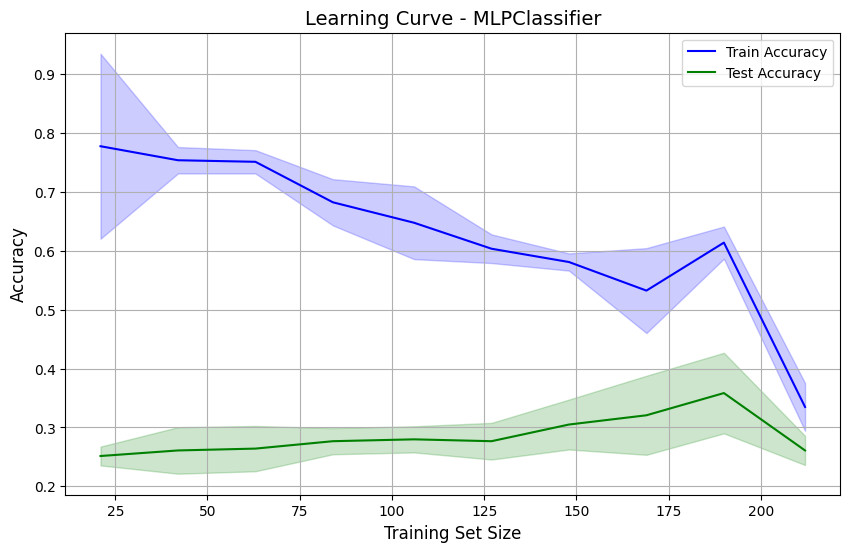

In [108]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

# Menggunakan model terbaik dari RandomizedSearchCV
best_mlp_random = random_search.best_estimator_

# Mendapatkan learning curve
train_sizes, train_scores, test_scores = learning_curve(
    best_mlp_random, X_train, y_train, 
    cv=3, n_jobs=-1, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10)
)

# Menghitung rata-rata dan standar deviasi untuk score train dan test
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, color='blue', label='Train Accuracy')
plt.plot(train_sizes, test_mean, color='green', label='Test Accuracy')

# Tambahkan shading untuk menunjukkan standar deviasi
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='blue', alpha=0.2)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color='green', alpha=0.2)

# Menambahkan label dan judul
plt.title('Learning Curve - MLPClassifier', fontsize=14)
plt.xlabel('Training Set Size', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(loc='best')
plt.grid(True)
plt.show()
